## imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import torch
from torch import nn

import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle


sns.set()

## preprocessing data

In [2]:
def data_preprocessing_input(type_data,name_data,dataset_path):
    
    updated_data_df = pd.DataFrame()
    path_file = f"{dataset_path}{name_data}"

    if type_data == 'raQTL':
        old_data_df = pd.read_csv(path_file, sep='\t')
        updated_data_df['Chromosome'] = old_data_df['chr']
        updated_data_df['Position'] = old_data_df['SNPabspos']
        updated_data_df['Reference'] = old_data_df['ref']
        updated_data_df['Alternative'] = old_data_df['alt']
        if 'hepg2' in  name_data:
            type_cell = 'hepg2'
        else:
            type_cell = 'k562'    
        updated_data_df['Value_Ratio_log2'] = np.log2(old_data_df[f'{type_cell}.alt.mean']/old_data_df[f'{type_cell}.ref.mean'])
        updated_data_df['Value_Diff'] = old_data_df[f'{type_cell}.alt.mean']-old_data_df[f'{type_cell}.ref.mean']
        updated_data_df['Value_Pvalue_signed'] = -np.log10(old_data_df[f'{type_cell}.wilcox.p.value'])*np.sign(updated_data_df['Value_Ratio_log2'])
        updated_data_df['P_value'] = old_data_df[f'{type_cell}.wilcox.p.value']
    elif type_data == 'mpra':
        old_data_df = pd.read_csv(path_file)
        if 'GSE87711' in name_data:  
            updated_data_df['Chromosome'] = old_data_df['chr'].apply(lambda x: f'chr{x}')
            updated_data_df['Position'] = old_data_df['pos']
            updated_data_df['Reference'] = old_data_df['ref']
            updated_data_df['Alternative'] = old_data_df['alt']
            updated_data_df['Value_Ratio_log2'] = np.log2(old_data_df['CTRL.fc(log2)'])
            updated_data_df['Value_Diff'] = old_data_df['CTRL.padj']-old_data_df['CTRL.mut.padj']
            updated_data_df['Value_Pvalue_signed'] = -np.log10(old_data_df['CTRL.mut.p'])*np.sign(updated_data_df['Value_Ratio_log2'])
            updated_data_df['P_value'] = old_data_df['CTRL.mut.p']
        if 'SORT1' in name_data:
            updated_data_df['Chromosome'] = old_data_df['Chromosome'].apply(lambda x: f'chr{x}')
            updated_data_df['Position'] = old_data_df['Position']
            updated_data_df['Reference'] = old_data_df['Ref']
            updated_data_df['Alternative'] = old_data_df['Alt']
            updated_data_df['Value_Ratio_log2'] = old_data_df['VariantExpressionEffect (log2)']
            updated_data_df['Value_Pvalue_signed'] = -np.log10(old_data_df['P-value'])*np.sign(updated_data_df['Value_Ratio_log2'])
            updated_data_df['P_value'] = old_data_df['P-value']
        if 'GSE68331' in name_data:
            updated_data_df['Chromosome'] = old_data_df['chr3']
            updated_data_df['Position'] = old_data_df['Pos']
            updated_data_df['Reference'] = old_data_df['Allele0']
            updated_data_df['Alternative'] = old_data_df['Allele1']
            updated_data_df['Value_Ratio_log2'] = np.log2(old_data_df['effect'])
            updated_data_df['Value_Pvalue_signed'] = -np.log10(old_data_df['P'])*np.sign(updated_data_df['Value_Ratio_log2'])
            updated_data_df['P_value'] = old_data_df['P']
        if 'NPC_SNP' in name_data:
            updated_data_df['Chromosome'] = old_data_df['Chromosome']
            updated_data_df['Position'] = old_data_df['Central variant position (hg19)']
            updated_data_df['Reference'] = old_data_df['Archaic sequence sequence'].apply(lambda x: x[99])
            updated_data_df['Alternative'] = old_data_df['Modern sequence sequence'].apply(lambda x: x[99])
            updated_data_df['Value_Ratio_log2'] = old_data_df['Differential activity log2(fold-change) - modern vs archaic - NPC']
            updated_data_df['Value_Pvalue_signed'] = -np.log10(old_data_df['Differential activity P-value - NPC'])*np.sign(updated_data_df['Value_Ratio_log2'])
            updated_data_df['P_value'] = old_data_df['Differential activity P-value - NPC']
        if 'Hela' in name_data:
            updated_data_df['Chromosome'] = old_data_df['chromosome (hg19)']
            updated_data_df['Position'] = old_data_df['coordinate (hg19)']
            updated_data_df['Reference'] = old_data_df['Reference']
            updated_data_df['Alternative'] = old_data_df['Substitution']
            updated_data_df['Value_Ratio_log2'] = old_data_df['HeLa effect size']
            updated_data_df['Value_Pvalue_signed'] = -np.log10(old_data_df['HeLa P-Value'])*np.sign(updated_data_df['Value_Ratio_log2'])
            updated_data_df['P_value'] = old_data_df['HeLa P-Value']            
    return updated_data_df

# Example usage
#data_df = data_preprocessing_input(type_data,name_data,dataset_path)

### Load metadata

In [ ]:
data_to_source = pd.read_csv('/data/Dcode/gaetano/repos/AI4Genomic/data/data_mutagenesis.csv')
data_to_source['type_data'] = data_to_source['path'].apply(lambda x: x.split('/')[-2])
data_to_source.head(10)

,name,path,hg type,#samples,cell line,study,resource,BioS,type_data
0,k562.sign.id.LP190708.txt,/repos/AI4Genomic/data/raQTL/,hg19,19237,k562,PMID: 31253979,https://osf.io/6y9td/,BioS74,raQTL
1,hepg2.sign.id.LP190708.txt,/repos/AI4Genomic/data/raQTL/,hg19,14183,hepg2,PMID: 31253979,https://osf.io/6y9td/,BioS73,raQTL
2,SORT1.csv,/repos/AI4Genomic/data/mpra/,hg38,1789,hepg2,PMID: 31395865,https://pavlopoulos-lab.org/shinyapps/app/mpra...,BioS73,mpra
3,GSE87711.csv,/repos/AI4Genomic/data/mpra/,hg19,84,k562,PMID: 27259154,paper Sup. Mat.,BioS74,mpra
4,GSE68331_SNP.csv,/repos/AI4Genomic/data/mpra/,hg19,283,hepg2,PMID: 26084464,paper Sup. Mat.,BioS73,mpra
5,NPC_SNP.csv,/repos/AI4Genomic/data/mpra/,hg19,14042,NPC,PMID: 33885362,paper Sup. Mat.,BioS45,mpra
6,Hela_TRAF3IP2.csv,/repos/AI4Genomic/data/mpra/,hg19,1962,Hela,PMID: 25340400,paper Sup. Mat.,BioS2,mpra
7,Hela_PPARG.csv,/repos/AI4Genomic/data/mpra/,hg19,1614,Hela,PMID: 25340400,paper Sup. Mat.,BioS2,mpra
8,Hela_SORL1.csv,/repos/AI4Genomic/data/mpra/,hg19,1665,Hela,PMID: 25340400,paper Sup. Mat.,BioS2,mpra


## Dataset-wise

#### reshape predictions (get log 2 ratio)

In [4]:
def calculate_logit_ratio(ref_predictions, alt_predictions):
    """Calculate the log2 ratio of alt and ref probabilities using the sigmoid function."""
    ref_margin_logit = ref_predictions[:, 1] - ref_predictions[:, 0]
    alt_margin_logit = alt_predictions[:, 1] - alt_predictions[:, 0]

    ref_probability = 1 / (1 + np.exp(-ref_margin_logit))
    alt_probability = 1 / (1 + np.exp(-alt_margin_logit))

    return np.log2((alt_probability / ref_probability).numpy())

def load_pickle_predictions(file_path):
    """Load a pickle file and return its contents."""
    with open(file_path, 'rb') as file:
        return pickle.load(file, encoding='latin1')

def get_model_predictions(data, models_to_add, data_name):
    """Generate model predictions from data, including additional models."""
    model_predictions = {}

    # Process existing models
    for model, values in data.items():
        model_name = model.split('_')[0]
        model_predictions[model_name] = {
            'Value_Ratio_log2': calculate_logit_ratio(values['ref'], values['alt'])
        }

    # Add external models
    for model_name in models_to_add:
        path_model_pred = f'/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/{model_name}_{data_name}.pkl'
        external_data = load_pickle_predictions(path_model_pred)

        if 'tred' in model_name:
            external_data['diff_ratio'] = np.squeeze(external_data['predictions_alt'] / external_data['predictions_ref'])
        
        diff_ratio = external_data.get('diff_ratio', [])
        if not isinstance(diff_ratio, np.ndarray):
            diff_ratio = np.array(diff_ratio)

        model_predictions[model_name] = {
            'Value_Ratio_log2': np.log2(diff_ratio)
        }

    return model_predictions

def get_prediction_ratio_per_experiment(data_to_source):
    """Main function to compute prediction ratios for each experiment."""
    dict_results_per_experiment = {}

    for index, row in data_to_source.iterrows():
        data_name = row['name']
        dataset_path = f"/data/Dcode/gaetano{row['path']}"
        type_data = row['type_data']

        # Preprocess data and load model predictions
        data_df = data_preprocessing_input(type_data, data_name, dataset_path)
        file_path = f'/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/{data_name}.pkl'
        data = load_pickle_predictions(file_path)

        # Get all model predictions
        models_to_add = ['trednet', 'sei', 'enformer', 'borzoi']
        #models_to_add = ['trednet', 'sei', 'enformer']
        model_predictions = get_model_predictions(data, models_to_add, data_name)
        dict_results_per_experiment[index] = model_predictions

    return dict_results_per_experiment

dict_results_per_experiment = get_prediction_ratio_per_experiment(data_to_source)

/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pan

### preprocessing predictions to get correlation per dataset


In [5]:
def process_model_for_correlation_per_dataset(data_df, model_predictions):
    y = data_df['Value_Ratio_log2'].values
    
    for model_name, value in model_predictions.items():
        x = value['Value_Ratio_log2']

        # Create a mask to filter out both NaN and inf values
        mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)

        # Filter the data using the mask
        x_clean = x[mask]
        y_clean = y[mask]
        
        model_predictions[model_name]['data_points'] = (x_clean, y_clean)
        res = stats.linregress(x_clean, y_clean)
        model_predictions[model_name]['r_value'] = res.rvalue
        model_predictions[model_name]['p_value'] = res.pvalue
        model_predictions[model_name]['spearmanr'] = stats.spearmanr(x_clean, y_clean).correlation
        
        # Apply the P-value significance mask on the filtered data
        mask_sign = data_df['P_value'].values[mask] < 0.05

        model_predictions[model_name]['data_points_significant'] = (x_clean[mask_sign], y_clean[mask_sign])
        res = stats.linregress(x_clean[mask_sign], y_clean[mask_sign])
        model_predictions[model_name]['r_value_significant'] = res.rvalue
        model_predictions[model_name]['p_value_significant'] = res.pvalue
        model_predictions[model_name]['spearmanr_significant'] = stats.spearmanr(x_clean[mask_sign], y_clean[mask_sign]).correlation
        model_predictions[model_name]['spearmanr_significant_pvalue'] = stats.spearmanr(x_clean[mask_sign], y_clean[mask_sign]).pvalue
    
    return model_predictions




In [6]:
def get_correlation_per_dataset(data_to_source, dict_results_per_experiment):
    correlation_per_dataset = {}
    for index, row in data_to_source.iterrows():
        data_name = row['name']
        dataset_path = f"/data/Dcode/gaetano{row['path']}"
        type_data = row['type_data']

        # Preprocess data and load model predictions
        data_df = data_preprocessing_input(type_data, data_name, dataset_path)

        correlation_per_dataset[index] = process_model_for_correlation_per_dataset(data_df,dict_results_per_experiment[index])
    return correlation_per_dataset

#### Pearson correlation coefficient

In [7]:
# Extract dataset indices and model names
correlation_per_dataset = get_correlation_per_dataset(data_to_source, dict_results_per_experiment)

dataset_index = list(correlation_per_dataset.keys())  # Sort if order matters
models_name = list(correlation_per_dataset[dataset_index[0]].keys())

# Create a NumPy array to store r_value_significant
np_rvalues = np.zeros((len(models_name), len(dataset_index)))
np_pvalues = np.zeros((len(models_name), len(dataset_index)))

# Fill the NumPy array with r_value_significant
for row, model in enumerate(models_name):
    for col, exp in enumerate(dataset_index):
        np_rvalues[row, col] = correlation_per_dataset[exp][model]['r_value_significant']
        np_pvalues[row, col] = correlation_per_dataset[exp][model]['p_value_significant']

# Convert to DataFrame and apply absolute values
df = pd.DataFrame(np_rvalues, 
                  columns=[f"Dataset {idx+1}" for idx in dataset_index], 
                  index=models_name)


# Create a styled DataFrame with colored bars based on p-values
styled_df = df.style.bar(color='#5fba7d', axis=0)  # Default bar color (will be overridden)



# Display the styled DataFrame
styled_df


/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Cannot calculate a linear regression if all x values are identical

#### Spearman

In [8]:
# Extract dataset indices and model names
dataset_index = list(correlation_per_dataset.keys())  # Sort if order matters
models_name = list(correlation_per_dataset[dataset_index[0]].keys())

# Create a NumPy array to store r_value_significant
np_pear = np.zeros((len(models_name), len(dataset_index)))
np_pvalues = np.zeros((len(models_name), len(dataset_index)))

# Fill the NumPy array with r_value_significant
for row, model in enumerate(models_name):
    for col, exp in enumerate(dataset_index):
        np_pear[row, col] = correlation_per_dataset[exp][model]['spearmanr_significant']
        

# Convert to DataFrame and apply absolute values
df = pd.DataFrame(np_pear, 
                  columns=[f"Dataset {idx+1}" for idx in dataset_index], 
                  index=models_name)


# Create a styled DataFrame with colored bars based on p-values
styled_df = df.style.bar(color='#007bff', axis=0)  # Default bar color (will be overridden)

# Display the styled DataFrame
styled_df


,Dataset 1,Dataset 2,Dataset 3,Dataset 4,Dataset 5,Dataset 6,Dataset 7,Dataset 8,Dataset 9
dnabert2,0.136031,0.135830,0.102512,0.168164,0.105019,0.017686,0.627273,0.512949,0.335512
nucleotide-transformer-v2-50m-multi-species,0.193563,0.169643,0.191334,0.348239,-0.018275,0.028590,0.272727,0.496065,0.251806
nucleotide-transformer-v2-100m-multi-species,0.194391,0.203409,0.222203,0.135056,0.382497,0.015691,0.545455,0.442192,0.068574
nucleotide-transformer-v2-250m-multi-species,0.230847,0.171191,0.305842,0.196427,0.372201,0.026601,0.309091,0.507249,0.185595
nucleotide-transformer-v2-500m-multi-species,0.255726,0.187485,-0.020422,0.442314,0.226347,0.079436,0.263636,0.431696,-0.089424
nucleotide-transformer-500m-1000g,0.152636,0.187685,0.147888,0.428586,-0.077220,0.013566,0.345455,0.389679,0.064038
nucleotide-transformer-500m-human-ref,0.158177,0.169706,0.062033,0.527506,0.066152,0.006857,0.309091,0.415721,0.110999
nucleotide-transformer-2.5b-1000g,0.167780,0.173467,0.284919,0.487534,0.354698,0.016053,0.581818,0.494841,0.104100
nucleotide-transformer-2.5b-multi-species,0.227509,0.209312,0.341665,0.399920,0.305019,0.040238,0.427273,0.516537,0.072081
Geneformer,0.005852,0.030458,0.043887,0.330474,-0.075676,0.006960,0.027273,-0.039248,-0.017420


## Cell Line-wise


In [9]:
# Load TredNet predictions
cell_line_results = {}

for index, row in data_to_source.iterrows():
    cell_line = row['cell line']
    predictions_cell_line = dict_results_per_experiment[index]

    data_name = row['name']
    dataset_path = f"/data/Dcode/gaetano{row['path']}"
    type_data = row['type_data']

    # Preprocess data and load model predictions
    data_df = data_preprocessing_input(type_data, data_name, dataset_path)

    # Initialize cell line entry if needed
    cell_line_results.setdefault(cell_line, {})

    for key, prediction in predictions_cell_line.items():
        # Access or initialize key entry for Value_Ratio_log2 and Experiment_points
        if key not in cell_line_results[cell_line]:
            cell_line_results[cell_line][key] = {
                'Value_Ratio_log2': prediction['Value_Ratio_log2'],
                'Experiment_points': data_df['Value_Ratio_log2'].values
            }
        else:
            cell_line_results[cell_line][key]['Value_Ratio_log2'] = np.concatenate(
                (cell_line_results[cell_line][key]['Value_Ratio_log2'], prediction['Value_Ratio_log2']), axis=0
            )
            cell_line_results[cell_line][key]['Experiment_points'] = np.concatenate(
                (cell_line_results[cell_line][key]['Experiment_points'], data_df['Value_Ratio_log2'].values), axis=0
            )


/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pan

#### preprocessing predictions

In [10]:

def process_model_predictions(cell_line_results):
    model_predictions_cell_line = {}
    for cell_line, models in cell_line_results.items():
        for k,v in models.items():
            y = v['Experiment_points']
            x = v['Value_Ratio_log2']

            # Create a mask to filter out both NaN and inf values
            mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)

            # Filter the data using the mask
            x_clean = x[mask]
            y_clean = y[mask]
            
            #model_predictions[k]['data_points'] = (x_clean, y_clean)
            res = stats.linregress(x_clean, y_clean)
            if cell_line not in model_predictions_cell_line.keys():
                model_predictions_cell_line[cell_line] = {}
            if k not in model_predictions_cell_line[cell_line].keys():
                model_predictions_cell_line[cell_line][k] = {}
            model_predictions_cell_line[cell_line][k]['r_value'] = res.rvalue
            model_predictions_cell_line[cell_line][k]['p_value'] = res.pvalue
            model_predictions_cell_line[cell_line][k]['spearmanr'] = stats.spearmanr(x_clean, y_clean).correlation
        
                
    return model_predictions_cell_line


#### plots

In [11]:
cell_exp_results = process_model_predictions(cell_line_results)

# Extract dataset indices and model names
dataset_index = list(cell_exp_results.keys())  # Sort if order matters
models_name = list(cell_exp_results[dataset_index[0]].keys())

# Create a NumPy array to store r_value_significant
np_rval = np.zeros((len(models_name), len(dataset_index)))
np_pvalues = np.zeros((len(models_name), len(dataset_index)))

# Fill the NumPy array with r_value_significant
for row, model in enumerate(models_name):
    for col, exp in enumerate(dataset_index):
        np_rval[row, col] = cell_exp_results[exp][model]['r_value']
        

# Convert to DataFrame and apply absolute values
df = pd.DataFrame(np_rval, 
                  columns=[f"{idx}" for idx in dataset_index], 
                  index=models_name)


# Create a styled DataFrame with colored bars based on p-values
styled_df = df.style.bar(color='#007bff', axis=0)  # Default bar color (will be overridden)

# Display the styled DataFrame
styled_df

,k562,hepg2,NPC,Hela
dnabert2,0.085918,0.096438,-0.003868,0.119719
nucleotide-transformer-v2-50m-multi-species,0.146814,0.102777,0.019737,0.074303
nucleotide-transformer-v2-100m-multi-species,0.151657,0.126555,0.016376,0.041832
nucleotide-transformer-v2-250m-multi-species,0.165746,0.110143,0.022789,0.029556
nucleotide-transformer-v2-500m-multi-species,0.198614,0.114329,0.027894,0.036006
nucleotide-transformer-500m-1000g,0.122965,0.116305,0.001412,0.022447
nucleotide-transformer-500m-human-ref,0.149381,0.118679,0.013020,0.066524
nucleotide-transformer-2.5b-1000g,0.147165,0.111564,0.005003,0.087122
nucleotide-transformer-2.5b-multi-species,0.152927,0.138805,0.026518,0.066166
Geneformer,0.005219,0.027276,-0.001632,-0.007361


## Unify datasets


### data collection

In [27]:
# Load TredNet predictions
data_experiment = {'Value_Ratio_log2':[], 'p_values':[]}
model_predictions_all = {}

for index, row in data_to_source.iterrows():
    cell_line = row['cell line']

    data_name = row['name']
    dataset_path = f"/data/Dcode/gaetano{row['path']}"
    type_data = row['type_data']

    # Preprocess data and load model predictions
    data_df = data_preprocessing_input(type_data, data_name, dataset_path)

    data_experiment['Value_Ratio_log2'].extend(data_df['Value_Ratio_log2'].values)
    data_experiment['p_values'].extend(data_df['P_value'].values)

    for model_name, values in dict_results_per_experiment[index].items():
        if model_name not in model_predictions_all.keys():
            model_predictions_all[model_name]={}
            model_predictions_all[model_name]['Value_Ratio_log2'] = []
        model_predictions_all[model_name]['Value_Ratio_log2'].extend(values['Value_Ratio_log2'])



/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pan

In [31]:
def clean_predictions(model_predictions, data_exp):
    
    y = np.array(data_exp['Value_Ratio_log2'])
    
    for model, val in model_predictions.items():
        x = np.array(val['Value_Ratio_log2'])

        finite_mask = np.isfinite(x) & np.isfinite(y)
        x_clean = x[finite_mask]
        y_clean = y[finite_mask]

        model_predictions[model]['data_points_clean'] = (x_clean, y_clean)

    return model_predictions
    
    
    

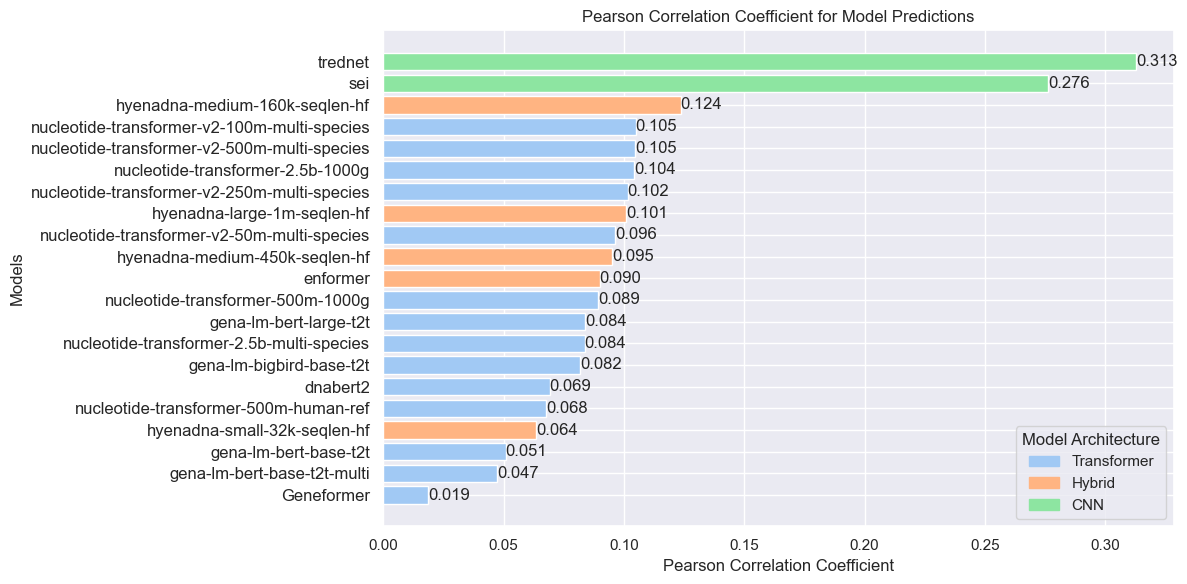

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set()

# Assuming dict_all_predictions is already populated with predictions
dict_all_predictions = clean_predictions(model_predictions_all, data_experiment)
models = list(dict_all_predictions.keys())

# Architecture mapping
architecture_mapping = {
    'dnabert2': 'Transformer',
    'nucleotide-transformer-v2-50m-multi-species': 'Transformer',
    'nucleotide-transformer-v2-100m-multi-species': 'Transformer',
    'nucleotide-transformer-v2-250m-multi-species': 'Transformer',
    'nucleotide-transformer-v2-500m-multi-species': 'Transformer',
    'nucleotide-transformer-500m-1000g': 'Transformer',
    'nucleotide-transformer-500m-human-ref': 'Transformer',
    'nucleotide-transformer-2.5b-1000g': 'Transformer',
    'nucleotide-transformer-2.5b-multi-species': 'Transformer',
    'Geneformer': 'Transformer',
    'gena-lm-bert-base-t2t': 'Transformer',
    'gena-lm-bert-large-t2t': 'Transformer',
    'gena-lm-bert-base-t2t-multi': 'Transformer',
    'gena-lm-bigbird-base-t2t': 'Transformer',
    'hyenadna-small-32k-seqlen-hf': 'Hybrid',
    'hyenadna-medium-160k-seqlen-hf': 'Hybrid',
    'hyenadna-medium-450k-seqlen-hf': 'Hybrid',
    'hyenadna-large-1m-seqlen-hf': 'Hybrid',
    'trednet': 'CNN',
    'sei': 'CNN',
    'enformer': 'Hybrid',
    'borzoi': 'Hybrid',
}

# Use Seaborn's pastel color palette
palette = sns.color_palette("pastel", n_colors=len(set(architecture_mapping.values())))

# Color mapping based on architectures
architecture_colors = {
    'Transformer': palette[0],  # First pastel color
    'Hybrid': palette[1],       # Second pastel color
    'CNN': palette[2],          # Third pastel color
}

# Calculating r-values and collecting architectures
r_values = []
architectures = []
for model in models:
    r_value = stats.linregress(dict_all_predictions[model]['data_points_clean']).rvalue
    r_values.append(r_value)
    architectures.append(architecture_mapping[model])  # Get architecture

# Sorting models, r-values, and architectures based on r-values
models_sorted, r_values_sorted, architectures_sorted = zip(
    *sorted(zip(models, r_values, architectures), key=lambda x: x[1])
)

# Create a figure and axis with increased width
fig, ax = plt.subplots(figsize=(12, 6))  # Adjusted width to 12

# Color mapping based on architectures
colors = [architecture_colors[arch] for arch in architectures_sorted]

# Horizontal bar plot for r-values (sorted)
bars = ax.barh(models_sorted, r_values_sorted, label='r-value', color=colors)

# Adding titles and labels
ax.set_title('Pearson Correlation Coefficient for Model Predictions')
ax.set_xlabel('Pearson Correlation Coefficient')
ax.set_ylabel('Models')

# Creating a custom legend for architectures
handles = [plt.Rectangle((0, 0), 1, 1, color=architecture_colors[arch]) for arch in architecture_colors]
labels = list(architecture_colors.keys())
ax.legend(handles, labels, title='Model Architecture')

# Adjusting y-tick font size
ax.tick_params(axis='y', labelsize=12)  # Adjust the label size as needed

# Adding r-value annotations
for i in range(len(r_values_sorted)):
    ax.text(r_values_sorted[i], i, f'{r_values_sorted[i]:.3f}', va='center')

# Show the plot with adjusted layout
plt.tight_layout()
plt.show()


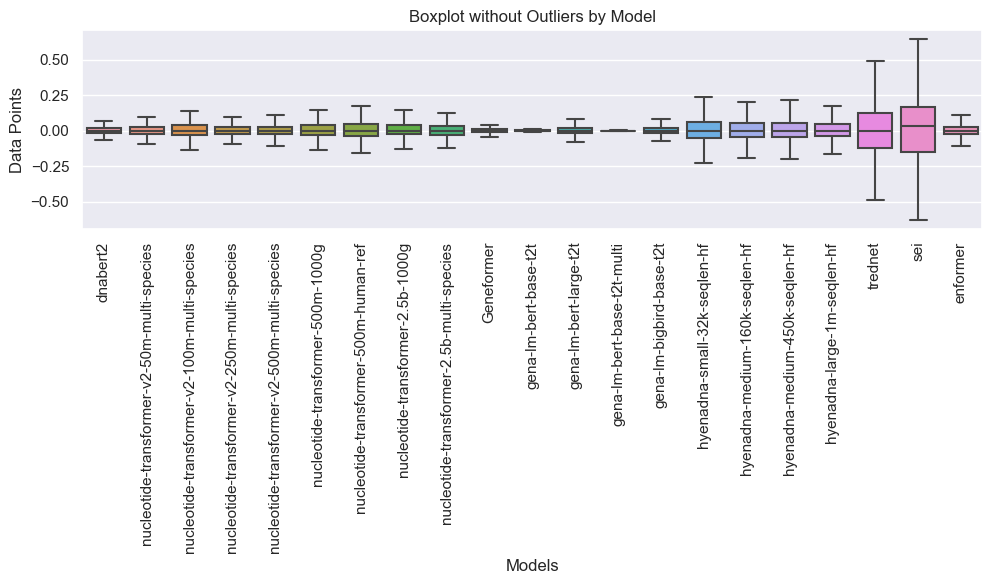

In [35]:

data = []
models = list(dict_all_predictions.keys())

# Flattening the data and associating them with their corresponding models
for model in models:
    data_points = dict_all_predictions[model]['data_points_clean'][0]  # First array of data_points
    for value in data_points:
        data.append({'Model': model, 'Data Point': value})

# Convert to pandas DataFrame for seaborn
df = pd.DataFrame(data)

# Create a boxplot for the data points without showing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Data Point', data=df, showfliers=False)

# Adding titles and labels
plt.title('Boxplot without Outliers by Model')
plt.xlabel('Models')
plt.ylabel('Data Points')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from typing import Dict

def plot_regression(df_full, df_significant_data, model, r_val):
    plt.figure(figsize=(10, 6))
    
    # Plot for the full dataset
    sns.regplot(
        x='Model log2 ratio',
        y='Experiment log2 ratio',
        data=df_full,
        scatter_kws={'alpha': 0.3},
        line_kws={'color': 'blue', 'alpha': 0.3},
        label=f"All data: r={r_val:.3f}"
    )
    
    # Color mapping for different p-value thresholds
    color_map = {
        0.05: 'red',       # p < 0.05
        0.01: 'orange',    # p < 0.01
        0.00005: 'green'   # p < 0.00005
    }
    
    # Plot for each significant dataset with its p-value threshold
    for (df_sig, threshold, r_val_sig) in df_significant_data:
        line_color = color_map.get(threshold, 'black')  # Default color if threshold is not found
        sns.regplot(
            x='Model log2 ratio (significant)',
            y='Experiment log2 ratio (significant)',
            data=df_sig,
            scatter_kws={'alpha': 0.3, 'color': line_color},
            line_kws={'color': line_color, 'alpha': 0.3},
            label=f"Significant data (p < {threshold}): r={r_val_sig:.3f}"
        )
    
    plt.ylabel('Experiment\nlog2(Alternative/Reference)')
    plt.xlabel('Model\nlog2(Alternative/Reference)')
    plt.title(f'{model} ({architecture_mapping[model]})')
    plt.legend()
    plt.show()

def process_models(dict_all_predictions: Dict):
    for model_name, value_dict in dict_all_predictions.items():
        # Ensure data points exist
        data_points = value_dict['data_points']
        p_values = value_dict['p_values']
        
        if len(data_points) != 2 or len(p_values) == 0:
            print(f"Skipping model {model_name}: Invalid data structure.")
            continue

        # Create a dataframe for the full dataset
        df_full = pd.DataFrame({
            'Model log2 ratio': data_points[0],
            'Experiment log2 ratio': data_points[1]
        })
        
        # Prepare to collect significant dataframes and their r-values
        df_significant_data = []
        
        # Filtering significant data points based on different p-value thresholds
        thresholds = [0.05, 0.01, 0.00005]
        for threshold in thresholds:
            mask = p_values < threshold
            filtered_data_points = (data_points[0][mask], data_points[1][mask])
            
            # Create a dataframe for the significant dataset
            df_significant = pd.DataFrame({
                'Model log2 ratio (significant)': filtered_data_points[0],
                'Experiment log2 ratio (significant)': filtered_data_points[1]
            })
            
            # Calculate correlation values
            r_val = stats.linregress(data_points).rvalue
            r_val_sig = stats.linregress(filtered_data_points).rvalue
            
            # Store the significant dataframe and r-value with the corresponding threshold
            df_significant_data.append((df_significant, threshold, r_val_sig))
        
        # Plot the regression with all significant data on the same plot
        plot_regression(df_full, df_significant_data, model_name, r_val)

# Call the function to process models
process_models(dict_all_predictions)
